Author: Jake VanderPlas

Comments and explanation to code added by ``Piotr Artman, 4th year Computer Science student, studentID: C00220223``.


This notebook is part of Python Data Science Handbook written by Jake VanderPlas.<br>
Content of this notebook is released under the [MIT License](LICENSE-CODE) .<br>
The text content of the book is released under the [CC-BY-NC-ND](LICENSE-TEXT) license.<br>
Comments added by ``Piotr Artman`` are also released under the [CC-BY-NC-ND](LICENSE-TEXT) license.<br>

# In Depth: Decision Trees and Random Forests

Previously we have looked in depth at a simple generative classifier (naive Bayes; see [In Depth: Naive Bayes Classification](05.05-Naive-Bayes.ipynb)) and a powerful discriminative classifier (support vector machines; see [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb)).
Here we'll take a look at another powerful algorithm: a nonparametric algorithm called *random forests*.
Random forests are an example of an *ensemble* method, meaning one that relies on aggregating the results of a set of simpler estimators.
The somewhat surprising result with such ensemble methods is that the sum can be greater than the parts: that is, the predictive accuracy of a majority vote among a number of estimators can end up being better than that of any of the individual estimators doing the voting!
We will see examples of this in the following sections.

We begin with the standard imports:

In [86]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
# orginal - seaborn-whitegrid
# print(plt.style.available)

***
``P.A.:``<p>
[Numpy](https://numpy.org) is library providing support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays and matrices. 
[Matplotlib](https://matplotlib.org) is ploting library, [pyplot](https://matplotlib.org/stable/tutorials/pyplot.html) is an interafce to matplotlib and provides ploting for graphs and acts like GUI manager by opening figures on the screen, [style](https://matplotlib.org/stable/gallery/pyplots/index.html) contains diffrent styles for ploting. By using <em style="font-family:Courier New">use</em> word we select parameters for ploting. ['seaborn-v0_8-whitegrid'](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html) style is used in this code. Orginal style <em style="font-family:Courier New">seaborn-whitegrid</em> is depreciated.<p>
<em style="font-family:Courier New">%matplotlib inline</em> command enables the inline plotting of figures directly below code cells in the notebook.<p>
<em style="font-family:Courier New">import numpy as np</em> imports [the NumPy library ](https://numpy.org) and assigns it the alias np.<p>
<em style="font-family:Courier New">import matplotlib.pyplot as plt</em> imports [the pyplot](https://matplotlib.org/stable/tutorials/pyplot.html) module the [the Matplotlib](https://matplotlib.org) library and assigns it the alias plt. <p>
<em style="font-family:Courier New">plt.style.use('seaborn-v0_8-whitegrid')</em> sets [the style of Matplotlib plots](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html) to the <em style="font-family:Courier New">seaborn-v0_8-whitegrid</em> style. This line is optional and affects the appearance of the plots. The <em style="font-family:Courier New">seaborn-v0_8-whitegrid</em> style provides a white background with grid lines, making the plots visually appealing.
***



## Motivating Random Forests: Decision Trees

Random forests are an example of an ensemble learner built on decision trees.
For this reason, we'll start by discussing decision trees themselves.

Decision trees are extremely intuitive ways to classify or label objects: you simply ask a series of questions designed to zero in on the classification.
For example, if you wanted to build a decision tree to classify animals you come across while on a hike, you might construct the one shown in the following figure.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Example)

The binary splitting makes this extremely efficient: in a well-constructed tree, each question will cut the number of options by approximately half, very quickly narrowing the options even among a large number of classes.
The trick, of course, comes in deciding which questions to ask at each step.
In machine learning implementations of decision trees, the questions generally take the form of axis-aligned splits in the data: that is, each node in the tree splits the data into two groups using a cutoff value within one of the features.
Let's now look at an example of this.

### Creating a Decision Tree

Consider the following two-dimensional data, which has one of four class labels (see the following figure):

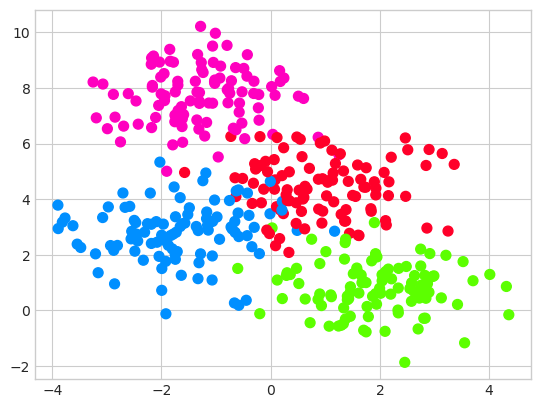

In [87]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=400, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='gist_rainbow');

***
``P.A.:``<p>
[Sklearn](https://scikit-learn.org/stable/) is a Python module for data learning; [datasets](https://scikit-learn.org/stable/datasets.html) is module used to load or fetch data; [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) is function for artificial sample generation. 

<em style="font-family:Courier New">from sklearn.datasets import make_blobs</em> imports the make_blobs function from [the sklearn.datasets](https://scikit-learn.org/stable/datasets.html) module. This function generates synthetic datasets with clusters.<br>
<em style="font-family:Courier New">X, y = make_blobs(n_samples=400, centers=4, random_state=0, cluster_std=1.0)</em> calls the [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) function to generate synthetic data.<p><b>The parameters are as follows:</b><p>
<em style="font-family:Courier New">n_samples</em> represents the total number of data points to generate (in this case, 400). Default value is 100. Points are equally divided among clusters<br>
<em style="font-family:Courier New">centers</em> represents number of centers (or clusters) to generate (in this case, 4). <br>
<em style="font-family:Courier New">random_state</em> represents seed for reproducibility. This is optional parameter. It allows to obtain the same synthetic datasets for consistent testing and evaluation.<br>
<em style="font-family:Courier New">cluster_std</em> represents standard deviation of clusters (in this case, 1.0). It controls dispersion of the points within each cluster.<p>
<b>The function returns two arrays:</b><p>
<em style="font-family:Courier New">X</em> is an array of <em style="font-family:Courier New">shape (n_samples, n_features)</em> representing the generated samples (coordinates for ploting points).<br>
<em style="font-family:Courier New">y</em> is an array of <em style="font-family:Courier New">shape (n_samples)</em> representing the <em style="font-family:Courier New">integer</em> labels for cluster membership (used for colorisation).<br><p>
<em style="font-family:Courier New">plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow')</em> creates a scatter plot using Matplotlib's scatter function. The parameters are as follows:<br>
<em style="font-family:Courier New">X[:, 0]</em> and <em style="font-family:Courier New">X[:, 1]</em>: The coordinates of the data points in the two dimensions.<br>
<em style="font-family:Courier New">c=y</em> colors the points based on the cluster labels stored in the <em style="font-family:Courier New">y</em> array.<br>
<em style="font-family:Courier New">s=50</em> specifies the size of the points in the scatter plot.<br>
<em style="font-family:Courier New">cmap='rainbow'</em>: Specifies the [Matplotlib's colormap](https://matplotlib.org/stable/users/explain/colors/colormaps.html) to use for coloring the points.<br>
***

A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it.
The following figure presents a visualization of the first four levels of a decision tree classifier for this data.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-levels.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Levels)

Notice that after the first split, every point in the upper branch remains unchanged, so there is no need to further subdivide this branch.
Except for nodes that contain all of one color, at each level *every* region is again split along one of the two features.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [88]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

***
``P.A.:``<p>
<em style="font-family:Courier New">from sklearn.tree import DecisionTreeClassifier</em> imports the [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class from the [sklearn.tree](https://scikit-learn.org/stable/modules/tree.html) module. This module contains  decision tree models for classification and regression. The [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) is a supervised learning algorithm used for classification tasks.<br>
<em style="font-family:Courier New">tree = DecisionTreeClassifier().tree.fit(X, y)</em> creates an instance of the <em style="font-family:Courier New">DecisionTreeClassifier class</em> and stores it in the variable <em style="font-family:Courier New">tree</em> then fits the <em style="font-family:Courier New">DecisionTreeClassifier</em> to the training data <em style="font-family:Courier New">X</em> and target data <em style="font-family:Courier New">y</em>. The training data consists of the features or independent variables, while the target data represents the labels or dependent variable. The fitting process involves constructing the decision tree model by learning the relationships between the features and the target variable. As result created model can then be used to make predictions on new data.
***

Let's write a utility function to help us visualize the output of the classifier:

In [89]:
def visualize_classifier(model, X, y, ax=None, cmap='gist_rainbow'):
    ax = ax or plt.gca()

    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)


***
``P.A.:``<p>
The <em style="font-family:Courier New">visualize_classifier</em> function creates a visual representation of the classifier's decision boundary and the training data points, allowing for a better understanding of the classifier's behavior and performance.<p>
The function <em style="font-family:Courier New">visualize_classifier</em> takes a trained classifier model <em style="font-family:Courier New">model</em>, training data <em style="font-family:Courier New">X</em>, and target data <em style="font-family:Courier New">y</em> as input, and optionally an Axes object <em style="font-family:Courier New">ax</em> and a colormap <em style="font-family:Courier New">cmap</em>. It creates a visualization of the classifier's decision boundary and the training data points.<p>
<em style="font-family:Courier New">ax = ax or plt.gca()</em>line checks if an Axes object <em style="font-family:Courier New">ax</em> is provided as input. If not, it uses the current Axes object from the plotting context <em style="font-family:Courier New">(plt.gca())</em><p>
<em style="font-family:Courier New">ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap, clim=(y.min(), y.max()), zorder=3)</em> line plots the training data points <em style="font-family:Courier New">X</em> on the Axes object <em style="font-family:Courier New">ax</em>. The color of each point corresponds to its target value <em style="font-family:Courier New">y</em>. The size of the points is set to 30, and the colormap <em style="font-family:Courier New">cmap</em> is used to represent the range of target values. The <em style="font-family:Courier New">clim</em> keyword argument sets the minimum and maximum values of the colormap to match the minimum and maximum target values. <p>
<em style="font-family:Courier New">model.fit(X, y)</em> line refits the classifier <em style="font-family:Courier New">model</em> model to the training data, ensuring that the latest changes to the model are reflected in the visualization.<p>
<em style="font-family:Courier New">xx, yy = np.meshgrid(np.linspace(*xlim, num=200),np.linspace(*ylim, num=200))</em> creates a meshgrid of points <em style="font-family:Courier New">(xx, yy)</em> covering the range of the training data's features (<em style="font-family:Courier New">xlim, ylim</em>). The meshgrid will be used to generate predictions for all possible combinations of features within the specified range.<p>
<em style="font-family:Courier New">Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)</em>predicts the target class for each point in the meshgrid <em style="font-family:Courier New">(xx, yy)</em> using the trained classifier <em style="font-family:Courier New">model</em> model. The predictions are stored in a 2D array <em style="font-family:Courier New">Z</em> with the same dimensions as the meshgrid.<p>
<em style="font-family:Courier New">n_classes = len(np.unique(y)) contours = ax.contourf(xx, yy, Z, alpha=0.3,levels=np.arange(n_classes + 1) - 0.5, cmap=cmap, zorder=1)</em>  line creates <em style="font-family:Courier New">contours</em> contours on the Axes object <em style="font-family:Courier New">ax</em> based on the prediction values <em style="font-family:Courier New">Z</em>. The contours represent the decision boundaries between the different classes. The alpha keyword argument sets the transparency of the contours. The levels keyword argument specifies the levels at which the contours should be drawn. The cmap keyword argument specifies the colormap used for the contours.<p>
<em style="font-family:Courier New">ax.set(xlim=xlim, ylim=ylim)</em>sets the Axes object's <em style="font-family:Courier New">ax</em> limits <em style="font-family:Courier New">xlim</em> and <em style="font-family:Courier New">ylim</em> to match the range of the training data's features.
***

Now we can examine what the decision tree classification looks like (see the following figure):

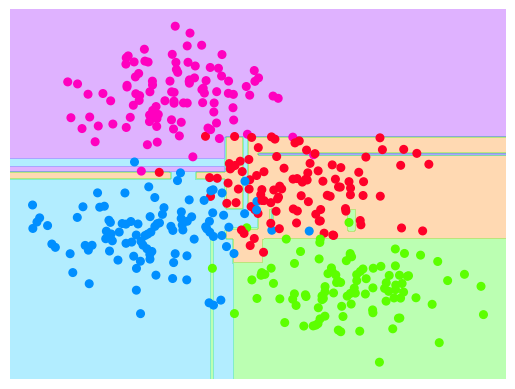

In [90]:
visualize_classifier(DecisionTreeClassifier(), X, y)

***
``P.A.:``<p>
<em style="font-family:Courier New">visualize_classifier(DecisionTreeClassifier(), X, y)</em>calls the <em style="font-family:Courier New">visualize_classifier</em> function, passing the newly created <em style="font-family:Courier New">DecisionTreeClassifier instance</em>, the training data <em style="font-family:Courier New">X</em>, and the target values <em style="font-family:Courier New">y</em> as arguments.<p>
The <em style="font-family:Courier New">visualize_classifier</em> function will then:<br>
1. Fit the DecisionTreeClassifier instance to the training data.<br>
2. Create a meshgrid of points covering the range of the training data's features.<br>
3. Predict the target class for each point in the meshgrid using the trained classifier.<br>
4. Create contours on the Axes object based on the prediction values.<br>
5. Set the Axes object's limits to match the range of the training data's features.<br>
***

If you're running this notebook live, you can use the helper script included in the online [appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Helper-Code) to bring up an interactive visualization of the decision tree building process:

In [91]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=1, options=(1, 5), value=5), Output()), _dom_classes…

***
``P.A.:``
***

Notice that as the depth increases, we tend to get very strangely shaped classification regions; for example, at a depth of five, there is a tall and skinny purple region between the yellow and blue regions.
It's clear that this is less a result of the true, intrinsic data distribution, and more a result of the particular sampling or noise properties of the data.
That is, this decision tree, even at only five levels deep, is clearly overfitting our data.

### Decision Trees and Overfitting

Such overfitting turns out to be a general property of decision trees: it is very easy to go too deep in the tree, and thus to fit details of the particular data rather than the overall properties of the distributions it is drawn from.
Another way to see this overfitting is to look at models trained on different subsets of the data—for example, in this figure we train two different trees, each on half of the original data.

![](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/images/05.08-decision-tree-overfitting.png?raw=1)
[figure source in Appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

It is clear that in some places the two trees produce consistent results (e.g., in the four corners), while in other places the two trees give very different classifications (e.g., in the regions between any two clusters).
The key observation is that the inconsistencies tend to happen where the classification is less certain, and thus by using information from *both* of these trees, we might come up with a better result!

If you are running this notebook live, the following function will allow you to interactively display the fits of trees trained on a random subset of the data:

In [92]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 100), value=0), Output()), _dom_classes…

***
``P.A.:``
***

Just as using information from two trees improves our results, we might expect that using information from many trees would improve our results even further.

## Ensembles of Estimators: Random Forests

This notion—that multiple overfitting estimators can be combined to reduce the effect of this overfitting—is what underlies an ensemble method called *bagging*.
Bagging makes use of an ensemble (a grab bag, perhaps) of parallel estimators, each of which overfits the data, and averages the results to find a better classification.
An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown here (see the following figure):

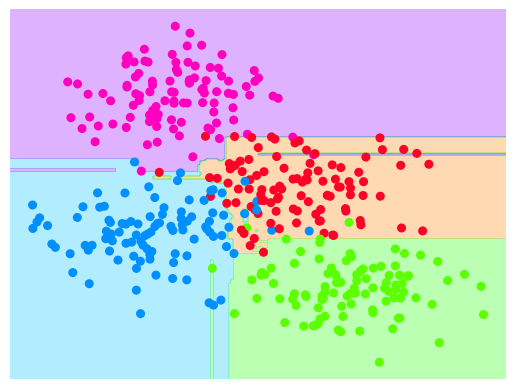

In [93]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

***
``P.A.:``<p>
The code above creates a bagged decision tree classifier, trains it on the provided data, and visualizes its decision boundary to gain insights into the model's behavior and performance.<p>
The steps involved:<p>
1. importing Libraries,<br>
2. creating Base Decision Tree Classifier,<br>
3. creating BaggingClassifier,<br>
4. fitting Bagged Classifier,<br>
5. visualizing classifier.<br>
<br>
<em style="font-family:Courier New">from sklearn.tree import DecisionTreeClassifier, from sklearn.ensemble import BaggingClassifier</em> this part of code imports the necessary libraries for creating and visualizing the bagged decision tree classifier.<br>
<em style="font-family:Courier New">tree = DecisionTreeClassifier()</em> line creates an instance of the DecisionTreeClassifier class, which serves as the base learner for the bagging ensemble<br>
<em style="font-family:Courier New">bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1)``</em> line creates an instance of the <em style="font-family:Courier New">BaggingClassifier class</em>, which aggregates predictions from multiple decision trees to improve overall performance. The <em style="font-family:Courier New">n_estimators</em> parameter sets the number of base decision trees to be trained, while <em style="font-family:Courier New">max_samples</em> specifies the proportion of training data used to train each tree. The <em style="font-family:Courier New">random_state</em> ensures reproducibility.<br>
<em style="font-family:Courier New">bag.fit(X, y)</em> line fits the bagged classifier <em style="font-family:Courier New">bag</em> to the training data <em style="font-family:Courier New">X</em> and target values <em style="font-family:Courier New">y</em>. This involves training each of the individual decision trees on different subsets of the data.<br>
<em style="font-family:Courier New">visualize_classifier(bag, X, y)</em> line calls the <em style="font-family:Courier New">visualize_classifier</em> function to create a visual representation of the bagged classifier's decision boundary and the training data. The <em style="font-family:Courier New">visualize_classifier</em> function will fit the ensemble model, create a meshgrid of points, predict target classes for each point, create contours based on predictions, and set axes limits.<br>
***

In this example, we have randomized the data by fitting each estimator with a random subset of 80% of the training points.
In practice, decision trees are more effectively randomized by injecting some stochasticity in how the splits are chosen: this way all the data contributes to the fit each time, but the results of the fit still have the desired randomness.
For example, when determining which feature to split on, the randomized tree might select from among the top several features.
You can read more technical details about these randomization strategies in the [Scikit-Learn documentation](http://scikit-learn.org/stable/modules/ensemble.html#forest) and references within.

In Scikit-Learn, such an optimized ensemble of randomized decision trees is implemented in the `RandomForestClassifier` estimator, which takes care of all the randomization automatically.
All you need to do is select a number of estimators, and it will very quickly—in parallel, if desired—fit the ensemble of trees (see the following figure):

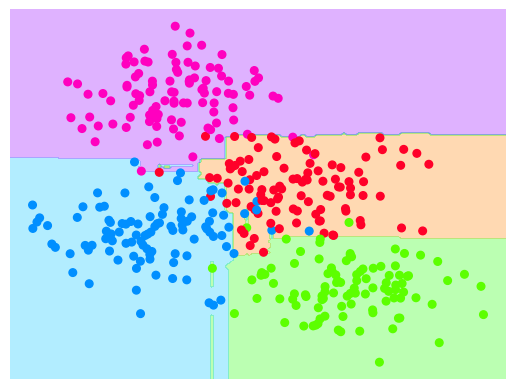

In [94]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
visualize_classifier(model, X, y)

***
``P.A.:``<p>
The above utilizes the sklearn library to create and visualize a random forest classifier.<p>
<em style="font-family:Courier New">from sklearn.ensemble import RandomForestClassifier</em> imports the RandomForestClassifier class from the sklearn.ensemble module. The RandomForestClassifier is a supervised learning algorithm used for classification tasks. It constructs a forest of decision trees, which are trained on different subsets of the data<br>
<em style="font-family:Courier New">model = RandomForestClassifier(n_estimators=100, random_state=42)</em> creates an instance of the <em style="font-family:Courier New">RandomForestClassifier class</em>. The <em style="font-family:Courier New">n_estimators</em> parameter specifies the number of decision trees to be trained (100 in this case). The <em style="font-family:Courier New">random_state</em> parameter ensures reproducibility by setting a random seed (42 in this case).
***

We see that by averaging over 100 randomly perturbed models, we end up with an overall model that is much closer to our intuition about how the parameter space should be split.

## Random Forest Regression

In the previous section we considered random forests within the context of classification.
Random forests can also be made to work in the case of regression (that is, with continuous rather than categorical variables). The estimator to use for this is the `RandomForestRegressor`, and the syntax is very similar to what we saw earlier.

Consider the following data, drawn from the combination of a fast and slow oscillation (see the following figure):

<ErrorbarContainer object of 3 artists>

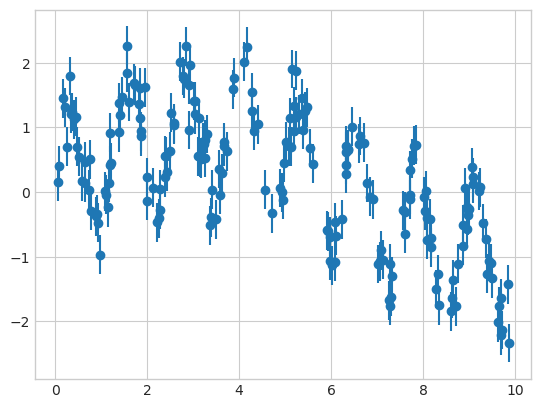

In [95]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o')

***
``P.A.:``<p>
The code above generates noisy sinusoidal data and plots it.<p>
<em style="font-family:Courier New">rng = np.random.RandomState(42)</em> creates a random number generator from the [Numpy](https://numpy.org) library. The <em style="font-family:Courier New">RandomState class</em> provides a variety of methods for generating random numbers from different distributions. The seed value <em style="font-family:Courier New">42</em> ensures reproducibility. <br>
<em style="font-family:Courier New">x = 10 * rng.rand(200)</em> generates an array of 200 random numbers between 0 and 10 using the <em style="font-family:Courier New">rand</em> method of the random number generator.<p>
The function <em style="font-family:Courier New">model(x, sigma=0.3)</em>defines a model that generates noisy data based on two sinusoidal oscillations and random noise.<p>
<b>This function takes two arguments:</b><p>
<em style="font-family:Courier New">x</em> - an array of input values<p>
<em style="font-family:Courier New">sigma</em> - the standard deviation of the noise (default value: 0.3)<p>
<b>and calculates three components:</b><p>
<em style="font-family:Courier New">fast_oscillation</em> - sinusoidal wave with a frequency of 5<p>
<em style="font-family:Courier New">slow_oscillation</em> - sinusoidal wave with a frequency of 0.5<p>
<em style="font-family:Courier New">noise</em> - random Gaussian noise with the specified standard deviation<p>
At the end this function returns the sum of these three components, representing the noisy output of the model.<p>
Line of code <em style="font-family:Courier New">y = model(x)</em> (below that function) generates the output of the model model using the input data <em style="font-family:Courier New">x</em>. The result is stored in the variable <em style="font-family:Courier New">y</em>.
***

Using the random forest regressor, we can find the best-fit curve as follows (see the following figure):

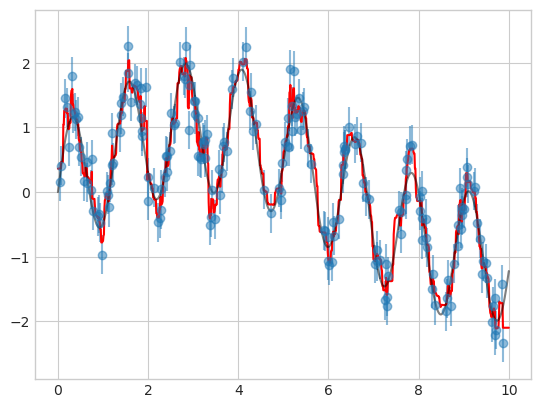

In [96]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200) # orginal value 200
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r')
plt.plot(xfit, ytrue, '-k', alpha=0.5)

***
``P.A.:``<p>
This code use the <em style="font-family:Courier New">RandomForestRegressor</em> to fit a model to noisy data and then make predictions on new data. It also shows how to plot the predicted and true model output to compare their performance.<p>
<em style="font-family:Courier New">from sklearn.ensemble imports RandomForestRegressor</em> imports the <em style="font-family:Courier New">RandomForestRegressor class</em> from the scikit-learn library. The <em style="font-family:Courier New">RandomForestRegressor</em> is a supervised learning algorithm used for regression tasks.<br>It constructs a forest of decision trees, which are trained on different subsets of the data and used to predict continuous target values.<p>
<em style="font-family:Courier New">forest = RandomForestRegressor(200)</em> creates an instance of the <em style="font-family:Courier New">RandomForestRegressor class</em> with 200 trees (<em style="font-family:Courier New">n_estimators=200</em>).<p>
<em style="font-family:Courier New">forest.fit(x[:, None], y)</em> fits that instance to the training data (<em style="font-family:Courier New">x</em>) and target values (<em style="font-family:Courier New">y</em>). The <em style="font-family:Courier New">x[:, None]</em> reshapes the input data (<em style="font-family:Courier New">x</em>) to ensure it has the correct dimensions for the <em style="font-family:Courier New">RandomForestRegressor</em>.<p>
<em style="font-family:Courier New">xfit = np.linspace(0, 10, 1000)</em> creates a new input array (<em style="font-family:Courier New">xfit</em>) with 1000 evenly spaced points between 0 and 10.<p>
<em style="font-family:Courier New">yfit = forest.predict(xfit[:, None])</em> - trained RandomForestRegressor (<em style="font-family:Courier New">forest</em>) is used to predict the target values (<em style="font-family:Courier New">yfit</em>) for these new input points.<p>
<em style="font-family:Courier New">ytrue = model(xfit, sigma=0)</em> generates the true model output (<em style="font-family:Courier New">ytrue</em>) for the new input data points (<em style="font-family:Courier New">xfit</em>) using the <em style="font-family:Courier New">model</em> function defined earlier.<p>
<em style="font-family:Courier New">plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)</em> creates an error bar plot using Matplotlib for the original training data (<em style="font-family:Courier New">x</em>, <em style="font-family:Courier New">y</em>). The error bars represent the standard deviation of the noise. The <em style="font-family:Courier New">alpha=0.5</em> parameter sets the transparency of the data points.<p>
Blue lines plot the predicted target values (<em style="font-family:Courier New">yfit</em>) for the new input data (<em style="font-family:Courier New">xfit</em>) as a red line and the true model output (<em style="font-family:Courier New">ytrue</em>) for the same data points as a black line with reduced transparency (<em style="font-family:Courier New">alpha=0.5</em>).
***

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
The nonparametric random forest model is flexible enough to fit the multiperiod data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classifying Digits

In Chapter 38 we worked through an example using the digits dataset included with Scikit-Learn.
Let's use that again here to see how the random forest classifier can be applied in this context:

In [97]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

***
``P.A.:``<p>
This code utilizes the [datasets](https://scikit-learn.org/stable/datasets.html)  module to load the [UCI Handwritten Digits](https://archive.ics.uci.edu/dataset/80/optical+recognition+of+handwritten+digits) dataset and retrieve its attributes.<p>
<em style="font-family:Courier New">from sklearn.datasets import load_digits</em> imports the <em style="font-family:Courier New">load_digits()</em> function from the <em style="font-family:Courier New">sklearn.datasets</em> module. This function provides a convenient way to access the UCI Handwritten Digits dataset.<p>
<em style="font-family:Courier New">digits = load_digits()</em> calls the <em style="font-family:Courier New">load_digits()</em> function to load the UCI Handwritten Digits dataset into a <em style="font-family:Courier New">Bunch</em> object <em style="font-family:Courier New">digits</em>. The <em style="font-family:Courier New">Bunch</em> object is a dictionary-like structure that encapsulates various aspects of the dataset, including the data samples, target labels, and descriptive information.<p>
<em style="font-family:Courier New">digits.keys()</em> calls the <em style="font-family:Courier New">keys()</em> method on the digits object. This method returns a list of all the attributes or keys associated with the dataset. These attributes provide access to different components of the dataset, such as the data itself, target labels, and descriptive information.<p>
***

To remind us what we're looking at, we'll visualize the first few data points (see the following figure):

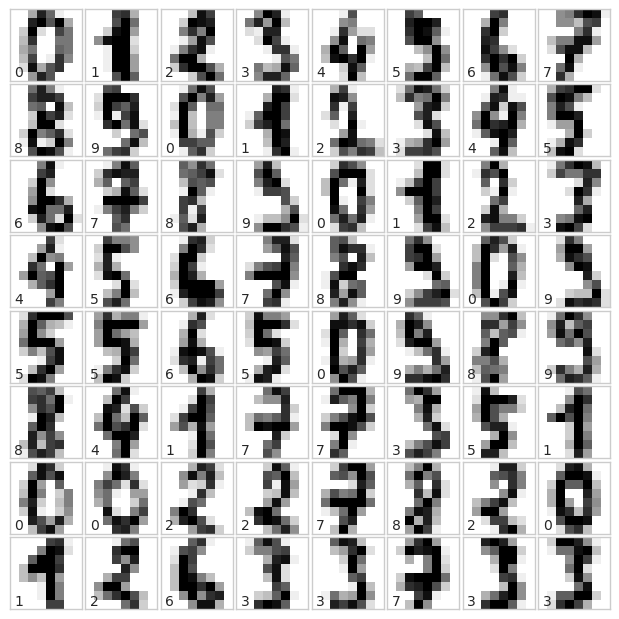

In [98]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')

    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

***
``P.A.:``<p>
<em style="font-family:Courier New">fig = plt.figure(figsize=(6, 6))</em> creates a new figure object using the <em style="font-family:Courier New">plt.figure()</em> function, specifying a figure size of 6 inches by 6 inches. 
<em style="font-family:Courier New">fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)</em> - <em style="font-family:Courier New">subplots_adjust()</em> function adjusts the layout of subplots within the figure, setting the left, right, bottom, and top margins to zero, ensuring that the images fill the entire figure. It also sets the horizontal and vertical spacing between subplots to 0.05, resulting in a tight grid layout.</p>
<em style="font-family:Courier New">for i in range(64)</em> - this loop iterates over the 64 images in the <em style="font-family:Courier New">digits.images</em> array.<p>
<em style="font-family:Courier New">   ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])</em> - for each image, is created a subplot using the <em style="font-family:Courier New">fig.add_subplot()</em> function, specifying the row and column positions (8 rows, 8 columns) and the subplot index (<em style="font-family:Courier New">i + 1</em>). The <em style="font-family:Courier New">xticks</em> and <em style="font-family:Courier New">yticks</em> arguments are set to empty lists to remove the axis ticks.<p>
<em style="font-family:Courier New">ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')</em> - the <em style="font-family:Courier New"> ax.imshow()</em> function displays the current image (<em style="font-family:Courier New">digits.images[i]</em>) within the <em style="font-family:Courier New">subplot</em>. The <em style="font-family:Courier New">cmap=plt.cm.binary</em> parameter sets the colormap <em style="font-family:Courier New">cmap</em>to binary, which represents the image pixels as black and white. The <em style="font-family:Courier New">interpolation='nearest'</em> parameter ensures that the image pixels are displayed without any smoothing or interpolation.
***

We can classify the digits using a random forest as follows:

In [99]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, ytrain, ytest = train_test_split(digits.data, digits.target,
                                                random_state=0)
model = RandomForestClassifier(n_estimators=1000)
model.fit(Xtrain, ytrain)
ypred = model.predict(Xtest)

***
``P.A.:``
***

Let's look at the classification report for this classifier:

In [100]:
from sklearn import metrics
print(metrics.classification_report(ypred, ytest))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99        38
           1       0.98      0.95      0.97        44
           2       0.95      1.00      0.98        42
           3       0.98      0.98      0.98        45
           4       0.97      1.00      0.99        37
           5       0.98      0.96      0.97        49
           6       1.00      1.00      1.00        52
           7       1.00      0.96      0.98        50
           8       0.94      0.98      0.96        46
           9       0.98      0.98      0.98        47

    accuracy                           0.98       450
   macro avg       0.98      0.98      0.98       450
weighted avg       0.98      0.98      0.98       450



***
``P.A.:``
***

And for good measure, plot the confusion matrix (see the following figure):

Text(118.78333333333332, 0.5, 'predicted label')

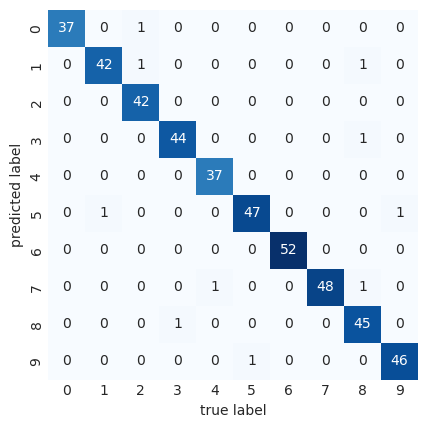

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(ytest, ypred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d',
            cbar=False, cmap='Blues')
plt.xlabel('true label')
plt.ylabel('predicted label')

***
``P.A.:``
***

We find that a simple, untuned random forest results in a quite accurate classification of the digits data.

## Summary

This chapter provided a brief introduction to the concept of ensemble estimators, and in particular the random forest, an ensemble of randomized decision trees.
Random forests are a powerful method with several advantages:

- Both training and prediction are very fast, because of the simplicity of the underlying decision trees. In addition, both tasks can be straightforwardly parallelized, because the individual trees are entirely independent entities.
- The multiple trees allow for a probabilistic classification: a majority vote among estimators gives an estimate of the probability (accessed in Scikit-Learn with the `predict_proba` method).
- The nonparametric model is extremely flexible and can thus perform well on tasks that are underfit by other estimators.

A primary disadvantage of random forests is that the results are not easily interpretable: that is, if you would like to draw conclusions about the *meaning* of the classification model, random forests may not be the best choice.